In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
import torch.nn.functional as func
#torch.manual_seed(50)




print(torch.__version__, torchvision.__version__)
torch.cuda.get_device_name(0)

/home/kjb/.conda/envs/lora/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.1+cu113 0.13.1+cu113


'NVIDIA RTX A5000'

In [2]:
# dst = datasets.CIFAR100("~/.torch", download=True)
# dst = datasets.MNIST("~/.torch", download=True)

tp = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=10):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

Running on cuda:0


In [3]:
# def weights_init(m):
#     if hasattr(m, "weight"):
#         m.weight.data.uniform_(-0.5, 0.5)
#         nn.init.xavier_uniform_(m.weight.data)
#     if hasattr(m, "bias"):
#         #m.bias.data.uniform_(-0.5, 0.5)
#         #nn.init.xavier_uniform(m.bias.data)
#         m.bias.data.fill_(0)



# class LeNet(nn.Module):

#     def __init__(self):

#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, kernel_size=5,stride=2)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=2)
#         self.fc1 = nn.Linear(16*5*5, 256)
#         self.fc2 = nn.Linear(256, 120)
#         self.fc3 = nn.Linear(120, 106)

#     def forward(self, x):
#         #x = func.relu(self.conv1(x))
#         x = func.sigmoid(self.conv1(x))
#         #x = func.max_pool2d(x, 2)
#         #x = func.relu(self.conv2(x))
#         x = func.sigmoid(self.conv2(x))
#         #x = func.max_pool2d(x, 2)
#         x = x.view(x.size(0), -1)
#         #x = func.relu(self.fc1(x))
#         x = func.sigmoid(self.fc1(x))
#         #x = func.relu(self.fc2(x))
#         x = func.sigmoid(self.fc2(x))
#         x = self.fc3(x)
#         return x

    
    
# def weights_init(m):
#     if hasattr(m, "weight"):
#         m.weight.data.uniform_(-0.3, 0.3)
#     if hasattr(m, "bias"):
#         m.bias.data.uniform_(-0.3, 0.3)


def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.1, 0.1)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.1, 0.1)


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        #act = nn.Tanh
        #act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(256, 256, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(256, 256, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(256, 256, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(65536, 106)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

    
class LeNet_attack(nn.Module):
    def __init__(self):
        super(LeNet_attack, self).__init__()
        act = nn.Sigmoid
        #act = nn.Tanh
        #act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(3072, 106)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

    
    

net = LeNet().to(device)
#net.apply(weights_init)

net1 = LeNet_attack().to(device)
net1.apply(weights_init)

#criterion = cross_entropy_for_onehot
criterion = nn.CrossEntropyLoss()

In [4]:
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
lfw_people=fetch_lfw_people(min_faces_per_person=14,color=True,slice_=(slice(61,189),slice(61,189)),resize=0.5)
x=lfw_people.images
y=lfw_people.target

target_names=lfw_people.target_names
n_classes=target_names.shape[0]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25,shuffle=False)


# #two people
# X_train_two = []
# y_train_two = []
# X_test_two = []
# y_test_two = []
# for ct_d in range(X_train.shape[0]):
#     if  y_train[ct_d] == 6:
#         X_train_two.append(X_train[ct_d])
#         y_train_two.append(0)
#     if  y_train[ct_d] == 9:
#         X_train_two.append(X_train[ct_d])
#         y_train_two.append(1)
        
# for ct_d in range(X_test.shape[0]):
#     if  y_train[ct_d] == 6:        
#         X_test_two.append(X_test[ct_d])
#         y_test_two.append(0)
#     if  y_train[ct_d] == 9:
#         X_test_two.append(X_test[ct_d])
#         y_test_two.append(1)
        
# X_train = np.asarray(X_train_two)    
# X_test = np.asarray(X_test_two)  
# y_train = np.asarray(y_train_two)  
# y_test = np.asarray(y_test_two)  

print (X_train.shape)
print (X_test.shape)

         
X_train = X_train.reshape(X_train.shape[0], 64, 64, 3)
X_test = X_test.reshape(X_test.shape[0], 64, 64, 3)
#X_train = torch.transpose
#X_train = X_train.astype('float32')
X_train /= 255.0
X_test /= 255.0

 


x_train = torch.FloatTensor(X_train).to(device)
x_train = x_train.transpose(2,3).transpose(1,2)
y_train = torch.LongTensor(y_train).to(device)

x_test = torch.FloatTensor(X_test).to(device)
x_test = x_test.transpose(2,3).transpose(1,2)
y_test = torch.LongTensor(y_test).to(device)


training = data.TensorDataset(x_train,y_train)

testing = data.TensorDataset(x_test,y_test)

dst_tensor=training

criterion_train = nn.CrossEntropyLoss()
optimizer_train = optim.Adam(net.parameters(),lr=0.01)#,momentum=0.9)
trainloader = torch.utils.data.DataLoader(training,batch_size=32, shuffle=True)

(2801, 64, 64, 3)
(934, 64, 64, 3)


In [5]:
iter_ = 0
for epoch in range(0):

    for i,data in enumerate(trainloader,0):
   
        #if epoch>=1:
        if i==1:
            #break
            iter_=iter_+1
            #print (iter_)
            inputs,label = data

            inputs,label =  Variable(inputs),Variable(label) 

            optimizer_train.zero_grad()


            outputs_benign=net(inputs)
            #outputs_benign = F.softmax(outputs_benign, dim=-1)
            #print (outputs_benign[0])


            loss_benign =  criterion_train(outputs_benign,label)

            #print("loss computed")
            loss_benign.backward()
            #print("loss BP")
            optimizer_train.step()

            #if i%2000==0:
            print (loss_benign.item())
            #torch.save(net.state_dict(),'./LFW_net.pth')  
       
  
print ('fininshed training')
total = len(y_test)
acc =0.0
for ct in range(total):
    testing_data = tt(testing[ct][0].cpu())
    testing_data1 = tp(testing_data).to(device)
    testing_data2 = testing_data1.view(1, *testing_data1.size())
    y_pred = net(testing_data2)
    predicted = torch.argmax(y_pred)
  
    if predicted == y_test[ct]:
        acc=acc+1
accuracy = acc / total
print (accuracy)
print ('fininshed testing')


fininshed training
0.007494646680942184
fininshed testing


torch.Size([100, 3, 64, 64])
torch.Size([100, 1])
torch.Size([100, 106])


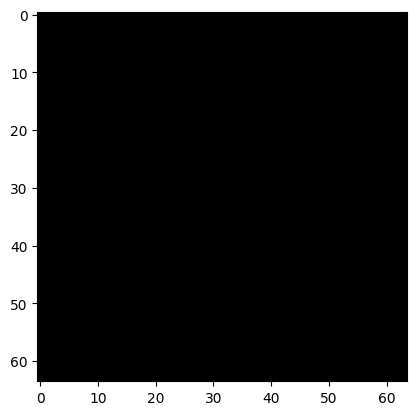

In [6]:

######### honest partipant #########
img_index = 0   #use img_index
dst_pil = tt(dst_tensor[img_index][0].cpu())   #use img_index

gt_data = tp(dst_pil).to(device)
gt_data = torch.unsqueeze(gt_data,0)

gt_label = dst_tensor[img_index][1].long().to(device) #use img_index
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=106)

plt.imshow(dst_pil)
#plt.savefig("./original/index_%s_label_%s"%(img_index,gt_label.item()))



batch = 100  #
for bat in range(batch-1):
    dst_pil = tt(dst_tensor[img_index+1+bat][0].cpu())   #use img_index
    tmp = torch.unsqueeze(tp(dst_pil).to(device),0)
    #print(tmp.shape)
    gt_data = torch.cat((gt_data,tmp),0)
    
    gt_label_tmp = dst_tensor[img_index+1+bat][1].long().to(device) #use img_index
    gt_label_tmp = gt_label_tmp.view(1, )
    gt_label = torch.cat((gt_label,gt_label_tmp),0)
    gt_onehot_label = torch.cat((gt_onehot_label,label_to_onehot(gt_label_tmp, num_classes=106)),0)

    plt.imshow(dst_pil)
    #plt.savefig("./original/index_%s_label_%s"%(bat+1,gt_label_tmp.item()))
    
    #plt.title("Ground truth image")
    #print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

    
gt_label = torch.reshape(gt_label,(-1,1))    
print (gt_data.shape)
print (gt_label.shape)
print (gt_onehot_label.shape)


# compute original gradient 
dy_dx = []
original_dy_dx=[]
original_pred = []
for item in range(batch):
    gt_data_single = torch.unsqueeze(gt_data[item],0)
    out = net(gt_data_single)
    #y = criterion(out, gt_onehot_label[item])
    y = criterion(out, gt_label[item])
    dy_dx = torch.autograd.grad(y, net.parameters(),retain_graph=True)
    original_dy_dx_tmp = list((_.detach().clone() for _ in dy_dx))
    original_dy_dx.append(original_dy_dx_tmp)
    out_tmp = out.detach().clone()
    original_pred.append(out_tmp)
    
    
    #dy_dx.append(torch.autograd.grad(y, net.parameters()))

    
    
# #FOR fully-connected model only
#     dw = net.body[0].weight
#     db = net.body[0].bias
#     dy_dw = torch.autograd.grad(y, dw,retain_graph=True)
#     dy_db = torch.autograd.grad(y, db,retain_graph=True)

#     print (dy_dw)
#     #print (dy_db.shape)

#     leak=dy_dw/dy_db

#     print (leak.shape)
    


# share the gradients with other clients
#original_dy_dx = list((_.detach().clone() for _ in dy_dx))


Dummy label is 59.
stolen label is 90.
0.670233441889286
Dummy label is 59.
stolen label is 89.
0.7189175643026828
Dummy label is 59.
stolen label is 47.
0.7232377961277962
Dummy label is 59.
stolen label is 92.
0.719640652090311
Dummy label is 59.
stolen label is 16.
0.7154821187257767
Dummy label is 59.
stolen label is 90.
0.7142802760004997
Dummy label is 59.
stolen label is 6.
0.7105173759162426
Dummy label is 59.
stolen label is 99.
0.7198292143642903
Dummy label is 59.
stolen label is 89.
0.7130796439945698
Dummy label is 59.
stolen label is 47.
0.7138803109526635
Dummy label is 59.
stolen label is 101.
0.7229790106415749
Dummy label is 59.
stolen label is 16.
0.7147070817649365
Dummy label is 59.
stolen label is 25.
0.7137029334902764
Dummy label is 59.
stolen label is 60.
0.7205143690109252
Dummy label is 59.
stolen label is 25.
0.7148393258452416
Dummy label is 59.
stolen label is 70.
0.7124505527317524
Dummy label is 59.
stolen label is 20.
0.7223196558654308
Dummy label is 5

/tmp/ipykernel_1427063/327054022.py:141: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 12))


0.719352626055479
Dummy label is 59.
stolen label is 26.
0.7140113614499569
Dummy label is 59.
stolen label is 25.
0.712372712790966
Dummy label is 59.
stolen label is 99.
0.764958356320858
Dummy label is 59.
stolen label is 16.
0.7652979597449303
Dummy label is 59.
stolen label is 35.
0.7625229924917221
Dummy label is 59.
stolen label is 75.
0.7702445216476917
Dummy label is 59.
stolen label is 91.
0.7662940710783005
Dummy label is 59.
stolen label is 37.
0.7645079821348191
Dummy label is 59.
stolen label is 21.
0.7744908131659031
Dummy label is 59.
stolen label is 7.
0.7652395159006119
Dummy label is 59.
stolen label is 36.
0.7639236107468605
Dummy label is 59.
stolen label is 32.
0.7698526747524739
Dummy label is 59.
stolen label is 25.
0.7643572896718979
Dummy label is 59.
stolen label is 65.
0.7604099787771702
Dummy label is 59.
stolen label is 50.
0.7730311959981918
Dummy label is 59.
stolen label is 83.
0.765528953820467
Dummy label is 59.
stolen label is 21.
0.7642778046429157


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

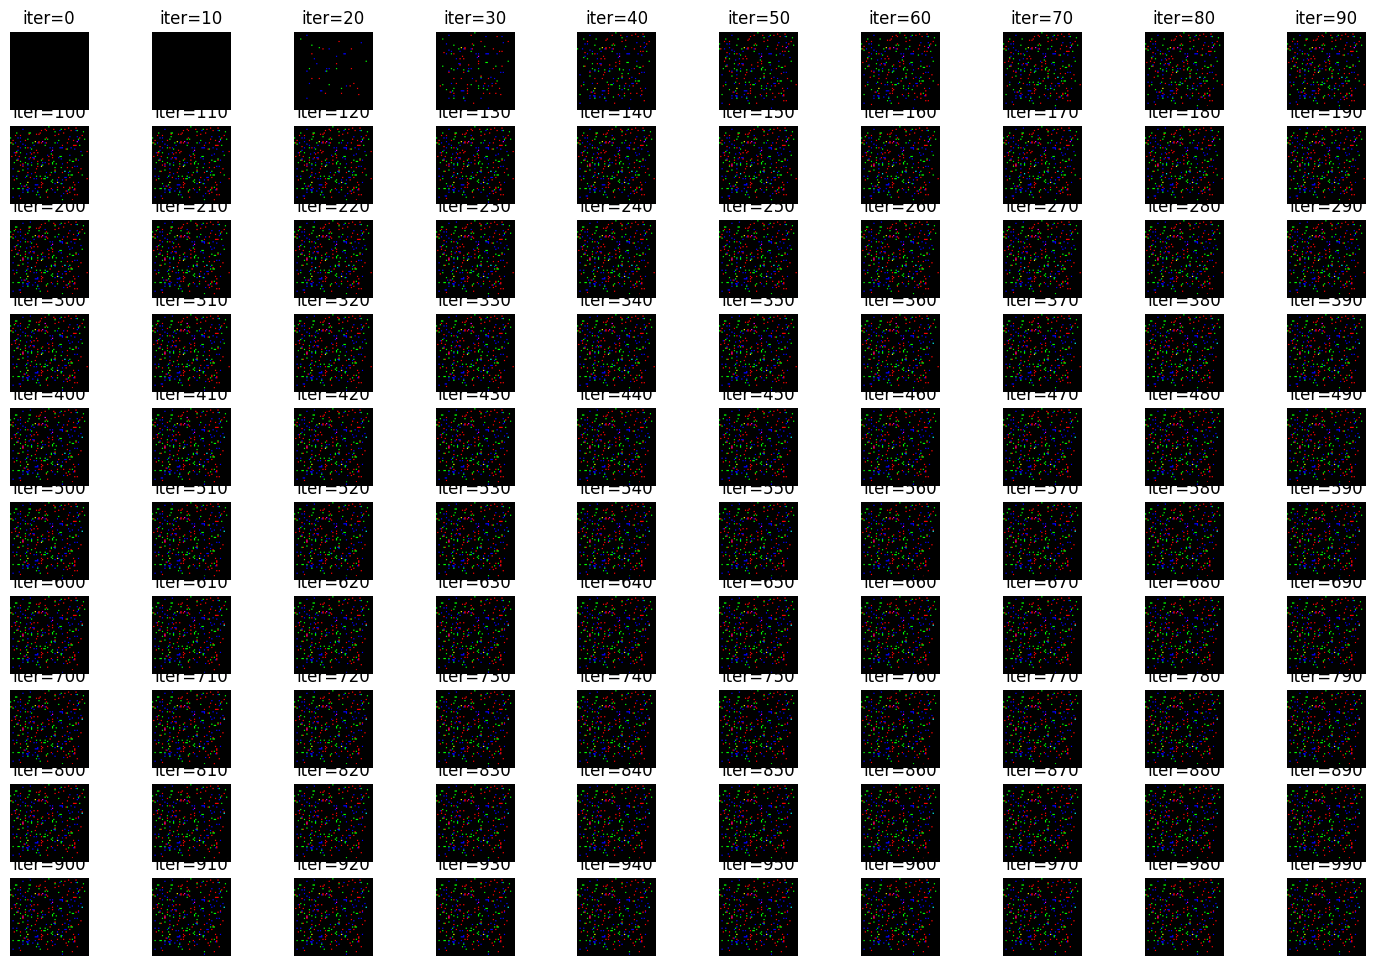

In [8]:
# generate dummy data and label
import time
 

for item in range(100):
    start = time.perf_counter()
    for rd in range(1):

        torch.manual_seed(10*rd)
        #dummy_data = torch.unsqueeze(torch.randn(gt_data[item].size()),0).to(device).requires_grad_(True)
        
        dummy_data = torch.unsqueeze(torch.zeros(gt_data[item].size()),0).to(device).requires_grad_(True)
        #dummy_data = torch.unsqueeze(torch.ones(gt_data[item].size()),0).to(device).requires_grad_(True)

        #surrogate = torch.unsqueeze(gt_data[item+1],0)
        #aaa = torch.rand([3,32,32])
        #surrogate[0,:,16:48,16:48] =aaa
        #dummy_data = surrogate.to(device).requires_grad_(True)    
        
        #dummy_data = torch.unsqueeze(gt_data[item+1],0).to(device).requires_grad_(True)
        
        #k=np.random.randint(0,100)
        #dummy_data = torch.unsqueeze(gt_data[k],0).to(device).requires_grad_(True)
        
        #aaa = torch.rand([3,32,32])
        #bbb = torch.cat((aaa,aaa),dim=1)
        #ccc = torch.cat((bbb,bbb),dim=2)
        #dummy_data = torch.unsqueeze(ccc,dim=0).to(device).requires_grad_(True)
        
        #background = torch.unsqueeze(torch.zeros(gt_data[item].size()),0)
        #background[0,2,::] = 1
        #dummy_data = background.to(device).requires_grad_(True)
        
        
        #aaa = torch.rand([3,16,16])
        #bbb = torch.cat((aaa,aaa),dim=1)
        #ccc = torch.cat((bbb,bbb),dim=1)
        #ddd = torch.cat((ccc,ccc),dim=2)
        #eee = torch.cat((ddd,ddd),dim=2)
        #dummy_data = torch.unsqueeze(eee,dim=0).to(device).requires_grad_(True)
        
        
        #dummy_data = plt.imread("./attack_image/replacement_69.png")
        #print (dummy_data.shape)
        #dummy_data = torch.FloatTensor(dummy_data).to(device)
        #dummy_data = dummy_data.transpose(2,3).transpose(1,2)
        
        dummy_label = torch.unsqueeze(torch.randn(gt_onehot_label[item].size()),dim=0).to(device).requires_grad_(True)
        label_pred=torch.argmin(torch.sum(original_dy_dx[item][-2], dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)
        #label_pred_onehot = label_to_onehot(label_pred, num_classes=106)

        
        plt.imshow(tt(dummy_data[0].cpu()))
        plt.title("Dummy data")
        #plt.savefig("./random_seed/index_%s_rand_seed_%s_label_%s"%(item,rd,torch.argmax(dummy_label, dim=-1).item()))

        plt.clf()
        print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
        print("stolen label is %d." % label_pred.item())
        
        
        #optimizer = torch.optim.LBFGS([dummy_data,])
        #optimizer = torch.optim.AdamW([dummy_data,dummy_label],lr=0.01)
        optimizer = torch.optim.AdamW([dummy_data],lr=0.01)
      
       

        history = []
        for iters in range(1000):
           
            
            def closure():
                optimizer.zero_grad()
                
                dummy_data_clip = torch.clamp(dummy_data,0,1)
                pred = net(dummy_data_clip) 
                dummy_onehot_label = F.softmax(dummy_label, dim=-1)
                #print (pred.shape)
                #print (dummy_onehot_label)
                #dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
             
                dummy_loss = criterion(pred, label_pred)
                dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
                #dummy_dy_dp = torch.autograd.grad(dummy_loss, dummy_data, create_graph=True)
                #print (dummy_dy_dp[0].shape)
                
                
                
                

                grad_diff = 0
                grad_count = 0
                count =0
                for gx, gy in zip(dummy_dy_dx, original_dy_dx[item]): # TODO: fix the variablas here
                   
                    #if iters==500 or iters== 1200:
                    #print (gx[0])
                    #    print ('hahaha')
                    #print (gy[0])
                    lasso = torch.norm(dummy_data,p=1)
                    ridge = torch.norm(dummy_data,p=2)
                    grad_diff += ((gx - gy) ** 2).sum() #+ 0.0*lasso +0.01*ridge 
                    #grad_diff += (torch.abs(original_pred[item]-pred)).sum()

                    
                    

                    grad_count += gx.nelement()
                

                    if count == 6:
                        break
                    count=count+1
                # grad_diff = grad_diff / grad_count * 1000
                grad_diff += ((original_pred[item]-pred)**2).sum()
             
                
                
                
                grad_diff.backward()
                #print (count)

                #print (dummy_dy_dx)
                #print (original_dy_dx)


                return grad_diff



            optimizer.step(closure)
            if iters % 5 == 0: 
                current_loss = closure()
                #if iters == 0: 
                #print ("%.8f" % current_loss.item())
                #print(iters, "%.8f" % current_loss.item())
            history.append(tt(dummy_data[0].cpu()))

        
        
        plt.figure(figsize=(18, 12))
        for i in range(100):
           plt.subplot(10, 10, i + 1)
           plt.imshow(history[i * 10])
           plt.title("iter=%d" % (i * 10))
           plt.axis('off')
        
        #print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
        #plt.savefig("./attack_image/64_index_%s_rand_%s_label_%s"%(item,rd, label_pred.item()))
        #plt.clf()
       
    duration = time.perf_counter()-start
    #print ("Running time is %.4f." %(duration/10.0) )
    print (duration/10.0 )
    
        

Dummy label is 59.


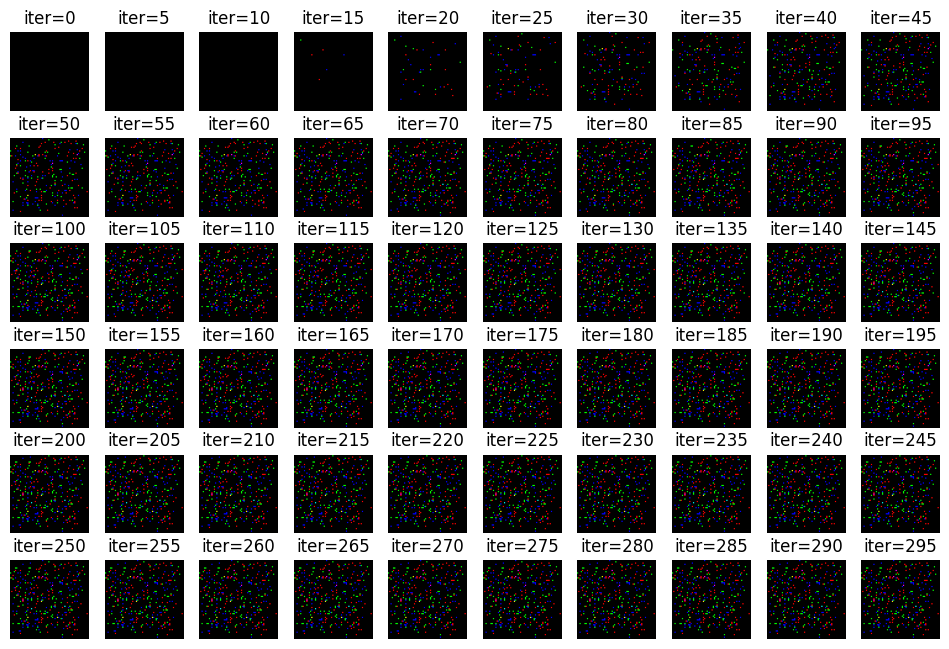

In [9]:
plt.figure(figsize=(12, 8))
for i in range(60):
  plt.subplot(6, 10, i + 1)
  plt.imshow(history[i * 5])
  plt.title("iter=%d" % (i * 5))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

NameError: name 'history_batch' is not defined

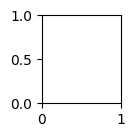

In [10]:
plt.figure(figsize=(12, 8))
for j in range(batch):
    for i in range(60):
      plt.subplot(6, 10, i + 1)
      plt.imshow(history_batch[i * 5+j])
      plt.title("iter=%d" % (i * 5+ j))
      plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())